In [ ]:
%%capture
!pip install tensorflow tensorflow-probability
!pip install d2l==1.0.0a1.post0

In [ ]:
import tensorflow as tf
from d2l import tensorflow as d2l

In [ ]:
X = tf.random.normal((1000, 2), 0.0, 1)
A = tf.constant([[1, 2], [-0.1, 0.5]])
b = tf.constant([1, 2], tf.float32)
data = tf.matmul(X, A) + b

The covariance matrix is
[[1.01 1.95]
 [1.95 4.25]]


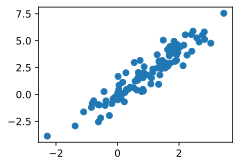

In [ ]:
d2l.set_figsize()
d2l.plt.scatter(data[:100, 0].numpy(), data[:100, 1].numpy());
print(f'The covariance matrix is\n{tf.matmul(A, A, transpose_a=True)}')


In [ ]:
batch_size = 8
data_iter = d2l.load_array((data,), batch_size)

## Generator

In [ ]:
net_G = tf.keras.layers.Dense(2)

## Discriminator

In [ ]:
net_D = tf.keras.models.Sequential([
    tf.keras.layers.Dense(5, activation="tanh", input_shape=(2,)),
    tf.keras.layers.Dense(3, activation="tanh"),
    tf.keras.layers.Dense(1)
])


## Training

In [1]:

def update_D(X, Z, net_D, net_G, loss, optimizer_D):
    """Update discriminator."""
    batch_size = X.shape[0]
    ones = tf.ones((batch_size,)) # Labels corresponding to real data
    zeros = tf.zeros((batch_size,)) # Labels corresponding to fake data
    # Do not need to compute gradient for `net_G`, so it's outside GradientTape
    fake_X = net_G(Z)
    with tf.GradientTape() as tape:
        real_Y = net_D(X)
        fake_Y = net_D(fake_X)
        # We multiply the loss by batch_size to match PyTorch's BCEWithLogitsLoss
        loss_D = (loss(ones, tf.squeeze(real_Y)) + loss(
            zeros, tf.squeeze(fake_Y))) * batch_size / 2
    grads_D = tape.gradient(loss_D, net_D.trainable_variables)
    optimizer_D.apply_gradients(zip(grads_D, net_D.trainable_variables))
    return loss_D

In [ ]:
def update_G(Z, net_D, net_G, loss, optimizer_G):
    """Update generator."""
    batch_size = Z.shape[0]
    ones = tf.ones((batch_size,))
    with tf.GradientTape() as tape:
        # We could reuse `fake_X` from `update_D` to save computation
        fake_X = net_G(Z)
        # Recomputing `fake_Y` is needed since `net_D` is changed
        fake_Y = net_D(fake_X)
        # We multiply the loss by batch_size to match PyTorch's BCEWithLogits loss
        loss_G = loss(ones, tf.squeeze(fake_Y)) * batch_size
    grads_G = tape.gradient(loss_G, net_G.trainable_variables)
    optimizer_G.apply_gradients(zip(grads_G, net_G.trainable_variables))
    return loss_G

Both the discriminator and the generator performs a binary logistic regression with the cross-entropy loss. We use Adam to smooth the training process. In each iteration, we first update the discriminator and then the generator. We visualize both losses and generated examples.

In [ ]:
def train(net_D, net_G, data_iter, num_epochs, lr_D, lr_G, latent_dim, data):
    loss = tf.keras.losses.BinaryCrossentropy(
        from_logits=True, reduction=tf.keras.losses.Reduction.SUM)
    for w in net_D.trainable_variables:
        w.assign(tf.random.normal(mean=0, stddev=0.02, shape=w.shape))
    for w in net_G.trainable_variables:
        w.assign(tf.random.normal(mean=0, stddev=0.02, shape=w.shape))
    optimizer_D = tf.keras.optimizers.Adam(learning_rate=lr_D)
    optimizer_G = tf.keras.optimizers.Adam(learning_rate=lr_G)
    animator = d2l.Animator(
        xlabel="epoch", ylabel="loss", xlim=[1, num_epochs], nrows=2,
        figsize=(5, 5), legend=["discriminator", "generator"])
    animator.fig.subplots_adjust(hspace=0.3)
    for epoch in range(num_epochs):
        # Train one epoch
        timer = d2l.Timer()
        metric = d2l.Accumulator(3)  # loss_D, loss_G, num_examples
        for (X,) in data_iter:
            batch_size = X.shape[0]
            Z = tf.random.normal(
                mean=0, stddev=1, shape=(batch_size, latent_dim))
            metric.add(update_D(X, Z, net_D, net_G, loss, optimizer_D),
                       update_G(Z, net_D, net_G, loss, optimizer_G),
                       batch_size)
        # Visualize generated examples
        Z = tf.random.normal(mean=0, stddev=1, shape=(100, latent_dim))
        fake_X = net_G(Z)
        animator.axes[1].cla()
        animator.axes[1].scatter(data[:, 0], data[:, 1])
        animator.axes[1].scatter(fake_X[:, 0], fake_X[:, 1])
        animator.axes[1].legend(["real", "generated"])

        # Show the losses
        loss_D, loss_G = metric[0] / metric[2], metric[1] / metric[2]
        animator.add(epoch + 1, (loss_D, loss_G))

    print(f'loss_D {loss_D:.3f}, loss_G {loss_G:.3f}, '
          f'{metric[2] / timer.stop():.1f} examples/sec')


Now we specify the hyperparameters to fit the Gaussian distribution.

loss_D 0.693, loss_G 0.693, 182.0 examples/sec


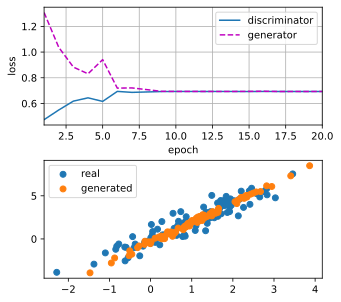

In [ ]:
lr_D, lr_G, latent_dim, num_epochs = 0.05, 0.005, 2, 20
train(net_D, net_G, data_iter, num_epochs, lr_D, lr_G,
      latent_dim, data[:100].numpy())


# Generative Adversarial Networks
:label:`sec_basic_gan`

Throughout most of this book, we have talked about how to make predictions. In some form or another, we used deep neural networks learned mappings from data examples to labels. This kind of learning is called discriminative learning, as in, we'd like to be able to discriminate between photos cats and photos of dogs. Classifiers and regressors are both examples of discriminative learning. And neural networks trained by backpropagation have upended everything we thought we knew about discriminative learning on large complicated datasets. Classification accuracies on high-res images has gone from useless to human-level (with some caveats) in just 5-6 years. We will spare you another spiel about all the other discriminative tasks where deep neural networks do astoundingly well.

But there is more to machine learning than just solving discriminative tasks. For example, given a large dataset, without any labels, we might want to learn a model that concisely captures the characteristics of this data. Given such a model, we could sample synthetic data examples that resemble the distribution of the training data. For example, given a large corpus of photographs of faces, we might want to be able to generate a new photorealistic image that looks like it might plausibly have come from the same dataset. This kind of learning is called generative modeling.

Until recently, we had no method that could synthesize novel photorealistic images. But the success of deep neural networks for discriminative learning opened up new possibilities. One big trend over the last three years has been the application of discriminative deep nets to overcome challenges in problems that we do not generally think of as supervised learning problems. The recurrent neural network language models are one example of using a discriminative network (trained to predict the next character) that once trained can act as a generative model.

In 2014, a breakthrough paper introduced Generative adversarial networks (GANs) :cite:`Goodfellow.Pouget-Abadie.Mirza.ea.2014`, a clever new way to leverage the power of discriminative models to get good generative models. At their heart, GANs rely on the idea that a data generator is good if we cannot tell fake data apart from real data. In statistics, this is called a two-sample test - a test to answer the question whether datasets $X=\{x_1,\ldots, x_n\}$ and $X'=\{x'_1,\ldots, x'_n\}$ were drawn from the same distribution. The main difference between most statistics papers and GANs is that the latter use this idea in a constructive way. In other words, rather than just training a model to say "hey, these two datasets do not look like they came from the same distribution", they use the [two-sample test](https://en.wikipedia.org/wiki/Two-sample_hypothesis_testing) to provide training signals to a generative model. This allows us to improve the data generator until it generates something that resembles the real data. At the very least, it needs to fool the classifier. Even if our classifier is a state of the art deep neural network.

![Generative Adversarial Networks](http://d2l.ai/_images/gan.svg)
:label:`fig_gan`


The GAN architecture is illustrated in :numref:`fig_gan`.
As you can see, there are two pieces in GAN architecture - first off, we need a device (say, a deep network but it really could be anything, such as a game rendering engine) that might potentially be able to generate data that looks just like the real thing. If we are dealing with images, this needs to generate images. If we are dealing with speech, it needs to generate audio sequences, and so on. We call this the generator network. The second component is the discriminator network. It attempts to distinguish fake and real data from each other. Both networks are in competition with each other. The generator network attempts to fool the discriminator network. At that point, the discriminator network adapts to the new fake data. This information, in turn is used to improve the generator network, and so on.


The discriminator is a binary classifier to distinguish if the input $x$ is real (from real data) or fake (from the generator). Typically, the discriminator outputs a scalar prediction $o\in\mathbb R$ for input $\mathbf x$, such as using a fully connected layer with hidden size 1, and then applies sigmoid function to obtain the predicted probability $D(\mathbf x) = 1/(1+e^{-o})$. Assume the label $y$ for the true data is $1$ and $0$ for the fake data. We train the discriminator to minimize the cross-entropy loss, *i.e.*,

$$ \min_D \{ - y \log D(\mathbf x) - (1-y)\log(1-D(\mathbf x)) \},$$

For the generator, it first draws some parameter $\mathbf z\in\mathbb R^d$ from a source of randomness, *e.g.*, a normal distribution $\mathbf z \sim \mathcal{N} (0, 1)$. We often call $\mathbf z$ as the latent variable.
It then applies a function to generate $\mathbf x'=G(\mathbf z)$. The goal of the generator is to fool the discriminator to classify $\mathbf x'=G(\mathbf z)$ as true data, *i.e.*, we want $D( G(\mathbf z)) \approx 1$.
In other words, for a given discriminator $D$, we update the parameters of the generator $G$ to maximize the cross-entropy loss when $y=0$, *i.e.*,

$$ \max_G \{ - (1-y) \log(1-D(G(\mathbf z))) \} = \max_G \{ - \log(1-D(G(\mathbf z))) \}.$$

If the generator does a perfect job, then $D(\mathbf x')\approx 1$ so the above loss near 0, which results the gradients are too small to make a good progress for the discriminator. So commonly we minimize the following loss:

$$ \min_G \{ - y \log(D(G(\mathbf z))) \} = \min_G \{ - \log(D(G(\mathbf z))) \}, $$

which is just feed $\mathbf x'=G(\mathbf z)$ into the discriminator but giving label $y=1$.


To sum up, $D$ and $G$ are playing a "minimax" game with the comprehensive objective function:

$$min_D max_G \{ -E_{x \sim \text{Data}} log D(\mathbf x) - E_{z \sim \text{Noise}} log(1 - D(G(\mathbf z))) \}.$$



Many of the GANs applications are in the context of images. As a demonstration purpose, we are going to content ourselves with fitting a much simpler distribution first. We will illustrate what happens if we use GANs to build the world's most inefficient estimator of parameters for a Gaussian. Let's get started.


In [ ]:
import tensorflow as tf
from d2l import tensorflow as d2l

## Generate Some "Real" Data

Since this is going to be the world's lamest example, we simply generate data drawn from a Gaussian.


In [ ]:
X = tf.random.normal((1000, 2), 0.0, 1)
A = tf.constant([[1, 2], [-0.1, 0.5]])
b = tf.constant([1, 2], tf.float32)
data = tf.matmul(X, A) + b

Let's see what we got. This should be a Gaussian shifted in some rather arbitrary way with mean $b$ and covariance matrix $A^TA$.


The covariance matrix is
[[1.01 1.95]
 [1.95 4.25]]


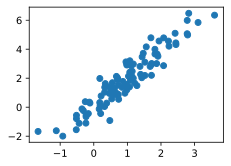

In [ ]:
d2l.set_figsize()
d2l.plt.scatter(data[:100, 0].numpy(), data[:100, 1].numpy());
print(f'The covariance matrix is\n{tf.matmul(A, A, transpose_a=True)}')

In [ ]:
batch_size = 8
data_iter = d2l.load_array((data,), batch_size)

## Generator

Our generator network will be the simplest network possible - a single layer linear model. This is since we will be driving that linear network with a Gaussian data generator. Hence, it literally only needs to learn the parameters to fake things perfectly.


In [ ]:
net_G = tf.keras.layers.Dense(2)

## Discriminator

For the discriminator we will be a bit more discriminating: we will use an MLP with 3 layers to make things a bit more interesting.


In [ ]:
net_D = tf.keras.models.Sequential([
    tf.keras.layers.Dense(5, activation="tanh", input_shape=(2,)),
    tf.keras.layers.Dense(3, activation="tanh"),
    tf.keras.layers.Dense(1)
])

## Training

First we define a function to update the discriminator.


In [ ]:
def update_D(X, Z, net_D, net_G, loss, optimizer_D):
    """Update discriminator."""
    batch_size = X.shape[0]
    ones = tf.ones((batch_size,)) # Labels corresponding to real data
    zeros = tf.zeros((batch_size,)) # Labels corresponding to fake data
    # Do not need to compute gradient for `net_G`, so it's outside GradientTape
    fake_X = net_G(Z)
    with tf.GradientTape() as tape:
        real_Y = net_D(X)
        fake_Y = net_D(fake_X)
        # We multiply the loss by batch_size to match PyTorch's BCEWithLogitsLoss
        loss_D = (loss(ones, tf.squeeze(real_Y)) + loss(
            zeros, tf.squeeze(fake_Y))) * batch_size / 2
    grads_D = tape.gradient(loss_D, net_D.trainable_variables)
    optimizer_D.apply_gradients(zip(grads_D, net_D.trainable_variables))
    return loss_D

The generator is updated similarly. Here we reuse the cross-entropy loss but change the label of the fake data from $0$ to $1$.


In [ ]:
def update_G(Z, net_D, net_G, loss, optimizer_G):
    """Update generator."""
    batch_size = Z.shape[0]
    ones = tf.ones((batch_size,))
    with tf.GradientTape() as tape:
        # We could reuse `fake_X` from `update_D` to save computation
        fake_X = net_G(Z)
        # Recomputing `fake_Y` is needed since `net_D` is changed
        fake_Y = net_D(fake_X)
        # We multiply the loss by batch_size to match PyTorch's BCEWithLogits loss
        loss_G = loss(ones, tf.squeeze(fake_Y)) * batch_size
    grads_G = tape.gradient(loss_G, net_G.trainable_variables)
    optimizer_G.apply_gradients(zip(grads_G, net_G.trainable_variables))
    return loss_G

Both the discriminator and the generator performs a binary logistic regression with the cross-entropy loss. We use Adam to smooth the training process. In each iteration, we first update the discriminator and then the generator. We visualize both losses and generated examples.


In [ ]:
def train(net_D, net_G, data_iter, num_epochs, lr_D, lr_G, latent_dim, data):
    loss = tf.keras.losses.BinaryCrossentropy(
        from_logits=True, reduction=tf.keras.losses.Reduction.SUM)
    for w in net_D.trainable_variables:
        w.assign(tf.random.normal(mean=0, stddev=0.02, shape=w.shape))
    for w in net_G.trainable_variables:
        w.assign(tf.random.normal(mean=0, stddev=0.02, shape=w.shape))
    optimizer_D = tf.keras.optimizers.Adam(learning_rate=lr_D)
    optimizer_G = tf.keras.optimizers.Adam(learning_rate=lr_G)
    animator = d2l.Animator(
        xlabel="epoch", ylabel="loss", xlim=[1, num_epochs], nrows=2,
        figsize=(5, 5), legend=["discriminator", "generator"])
    animator.fig.subplots_adjust(hspace=0.3)
    for epoch in range(num_epochs):
        # Train one epoch
        timer = d2l.Timer()
        metric = d2l.Accumulator(3)  # loss_D, loss_G, num_examples
        for (X,) in data_iter:
            batch_size = X.shape[0]
            Z = tf.random.normal(
                mean=0, stddev=1, shape=(batch_size, latent_dim))
            metric.add(update_D(X, Z, net_D, net_G, loss, optimizer_D),
                       update_G(Z, net_D, net_G, loss, optimizer_G),
                       batch_size)
        # Visualize generated examples
        Z = tf.random.normal(mean=0, stddev=1, shape=(100, latent_dim))
        fake_X = net_G(Z)
        animator.axes[1].cla()
        animator.axes[1].scatter(data[:, 0], data[:, 1])
        animator.axes[1].scatter(fake_X[:, 0], fake_X[:, 1])
        animator.axes[1].legend(["real", "generated"])

        # Show the losses
        loss_D, loss_G = metric[0] / metric[2], metric[1] / metric[2]
        animator.add(epoch + 1, (loss_D, loss_G))

    print(f'loss_D {loss_D:.3f}, loss_G {loss_G:.3f}, '
          f'{metric[2] / timer.stop():.1f} examples/sec')

Now we specify the hyperparameters to fit the Gaussian distribution.


loss_D 0.693, loss_G 0.693, 333.2 examples/sec


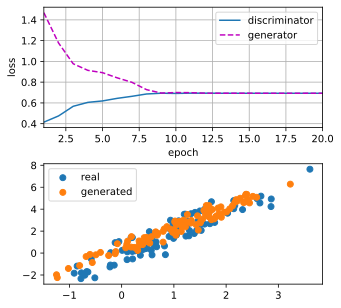

In [ ]:
lr_D, lr_G, latent_dim, num_epochs = 0.05, 0.005, 2, 20
train(net_D, net_G, data_iter, num_epochs, lr_D, lr_G,
      latent_dim, data[:100].numpy())

## Summary

* Generative adversarial networks (GANs) composes of two deep networks, the generator and the discriminator.
* The generator generates the image as much closer to the true image as possible to fool the discriminator, via maximizing the cross-entropy loss, *i.e.*, $\max \log(D(\mathbf{x'}))$.
* The discriminator tries to distinguish the generated images from the true images, via minimizing the cross-entropy loss, *i.e.*, $\min - y \log D(\mathbf{x}) - (1-y)\log(1-D(\mathbf{x}))$.

## Exercises

* Does an equilibrium exist where the generator wins, *i.e.* the discriminator ends up unable to distinguish the two distributions on finite samples?


# Deep Convolutional Generative Adversarial Networks
:label:`sec_dcgan`

In :numref:`sec_basic_gan`, we introduced the basic ideas behind how GANs work. We showed that they can draw samples from some simple, easy-to-sample distribution, like a uniform or normal distribution, and transform them into samples that appear to match the distribution of some dataset. And while our example of matching a 2D Gaussian distribution got the point across, it is not especially exciting.

In this section, we will demonstrate how you can use GANs to generate photorealistic images. We will be basing our models on the deep convolutional GANs (DCGAN) introduced in :citet:`Radford.Metz.Chintala.2015`. We will borrow the convolutional architecture that have proven so successful for discriminative computer vision problems and show how via GANs, they can be leveraged to generate photorealistic images.


In [ ]:
import tensorflow as tf
from d2l import tensorflow as d2l

## The Pokemon Dataset

The dataset we will use is a collection of Pokemon sprites obtained from [pokemondb](https://pokemondb.net/sprites). First download, extract and load this dataset.


In [ ]:
d2l.DATA_HUB['pokemon'] = (d2l.DATA_URL + 'pokemon.zip',
                           'c065c0e2593b8b161a2d7873e42418bf6a21106c')

data_dir = d2l.download_extract('pokemon')
batch_size = 256
pokemon = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir, batch_size=batch_size, image_size=(64, 64))

Found 40597 files belonging to 721 classes.


We resize each image into $64\times 64$. The `ToTensor` transformation will project the pixel value into $[0, 1]$, while our generator will use the tanh function to obtain outputs in $[-1, 1]$. Therefore we normalize the data with $0.5$ mean and $0.5$ standard deviation to match the value range.


In [ ]:
def transform_func(X):
    X = X / 255.
    X = (X - 0.5) / (0.5)
    return X

# For TF>=2.4 use `num_parallel_calls = tf.data.AUTOTUNE`
data_iter = pokemon.map(lambda x, y: (transform_func(x), y),
                        num_parallel_calls=tf.data.experimental.AUTOTUNE)
data_iter = data_iter.cache().shuffle(buffer_size=1000).prefetch(
    buffer_size=tf.data.experimental.AUTOTUNE)

Let's visualize the first 20 images.


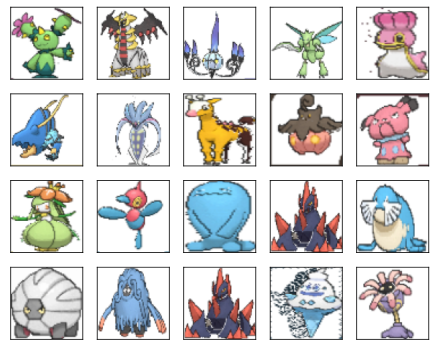

In [ ]:
d2l.set_figsize(figsize=(4, 4))
for X, y in data_iter.take(1):
    imgs = X[:20, :, :, :] / 2 + 0.5
    d2l.show_images(imgs, num_rows=4, num_cols=5)

## The Generator

The generator needs to map the noise variable $\mathbf z\in\mathbb R^d$, a length-$d$ vector, to a RGB image with width and height to be $64\times 64$ . In :numref:`sec_fcn` we introduced the fully convolutional network that uses transposed convolution layer (refer to :numref:`sec_transposed_conv`) to enlarge input size. The basic block of the generator contains a transposed convolution layer followed by the batch normalization and ReLU activation.


In [ ]:
class G_block(tf.keras.layers.Layer):
    def __init__(self, out_channels, kernel_size=4, strides=2, padding="same",
                 **kwargs):
        super().__init__(**kwargs)
        self.conv2d_trans = tf.keras.layers.Conv2DTranspose(
            out_channels, kernel_size, strides, padding, use_bias=False)
        self.batch_norm = tf.keras.layers.BatchNormalization()
        self.activation = tf.keras.layers.ReLU()

    def call(self, X):
        return self.activation(self.batch_norm(self.conv2d_trans(X)))

In default, the transposed convolution layer uses a $k_h = k_w = 4$ kernel, a $s_h = s_w = 2$ strides, and a $p_h = p_w = 1$ padding. With a input shape of $n_h^{'} \times n_w^{'} = 16 \times 16$, the generator block will double input's width and height.

$$
\begin{aligned}
n_h^{'} \times n_w^{'} &= [(n_h k_h - (n_h-1)(k_h-s_h)- 2p_h] \times [(n_w k_w - (n_w-1)(k_w-s_w)- 2p_w]\\
  &= [(k_h + s_h (n_h-1)- 2p_h] \times [(k_w + s_w (n_w-1)- 2p_w]\\
  &= [(4 + 2 \times (16-1)- 2 \times 1] \times [(4 + 2 \times (16-1)- 2 \times 1]\\
  &= 32 \times 32 .\\
\end{aligned}
$$


In [ ]:
x = tf.zeros((2, 16, 16, 3))  # Channel last convention
g_blk = G_block(20)
g_blk(x).shape

TensorShape([2, 32, 32, 20])

If changing the transposed convolution layer to a $4\times 4$ kernel, $1\times 1$ strides and zero padding. With a input size of $1 \times 1$, the output will have its width and height increased by 3 respectively.


In [ ]:
x = tf.zeros((2, 1, 1, 3))
# `padding="valid"` corresponds to no padding
g_blk = G_block(20, strides=1, padding="valid")
g_blk(x).shape

TensorShape([2, 4, 4, 20])

The generator consists of four basic blocks that increase input's both width and height from 1 to 32. At the same time, it first projects the latent variable into $64\times 8$ channels, and then halve the channels each time. At last, a transposed convolution layer is used to generate the output. It further doubles the width and height to match the desired $64\times 64$ shape, and reduces the channel size to $3$. The tanh activation function is applied to project output values into the $(-1, 1)$ range.


In [ ]:
n_G = 64
net_G = tf.keras.Sequential([
    # Output: (4, 4, 64 * 8)
    G_block(out_channels=n_G*8, strides=1, padding="valid"),
    G_block(out_channels=n_G*4), # Output: (8, 8, 64 * 4)
    G_block(out_channels=n_G*2), # Output: (16, 16, 64 * 2)
    G_block(out_channels=n_G), # Output: (32, 32, 64)
    # Output: (64, 64, 3)
    tf.keras.layers.Conv2DTranspose(
        3, kernel_size=4, strides=2, padding="same", use_bias=False,
        activation="tanh")
])

Generate a 100 dimensional latent variable to verify the generator's output shape.


In [ ]:
x = tf.zeros((1, 1, 1, 100))
net_G(x).shape

TensorShape([1, 64, 64, 3])

## Discriminator

The discriminator is a normal convolutional network network except that it uses a leaky ReLU as its activation function. Given $\alpha \in[0, 1]$, its definition is

$$\textrm{leaky ReLU}(x) = \begin{cases}x & \text{if}\ x > 0\\ \alpha x &\text{otherwise}\end{cases}.$$

As it can be seen, it is normal ReLU if $\alpha=0$, and an identity function if $\alpha=1$. For $\alpha \in (0, 1)$, leaky ReLU is a nonlinear function that give a non-zero output for a negative input. It aims to fix the "dying ReLU" problem that a neuron might always output a negative value and therefore cannot make any progress since the gradient of ReLU is 0.


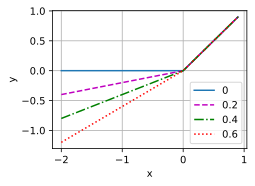

In [ ]:
alphas = [0, .2, .4, .6, .8, 1]
x = tf.range(-2, 1, 0.1)
Y = [tf.keras.layers.LeakyReLU(alpha)(x).numpy() for alpha in alphas]
d2l.plot(x.numpy(), Y, 'x', 'y', alphas)

The basic block of the discriminator is a convolution layer followed by a batch normalization layer and a leaky ReLU activation. The hyperparameters of the convolution layer are similar to the transpose convolution layer in the generator block.


In [ ]:
class D_block(tf.keras.layers.Layer):
    def __init__(self, out_channels, kernel_size=4, strides=2, padding="same",
                 alpha=0.2, **kwargs):
        super().__init__(**kwargs)
        self.conv2d = tf.keras.layers.Conv2D(out_channels, kernel_size,
                                             strides, padding, use_bias=False)
        self.batch_norm = tf.keras.layers.BatchNormalization()
        self.activation = tf.keras.layers.LeakyReLU(alpha)

    def call(self, X):
        return self.activation(self.batch_norm(self.conv2d(X)))

A basic block with default settings will halve the width and height of the inputs, as we demonstrated in :numref:`sec_padding`. For example, given a input shape $n_h = n_w = 16$, with a kernel shape $k_h = k_w = 4$, a stride shape $s_h = s_w = 2$, and a padding shape $p_h = p_w = 1$, the output shape will be:

$$
\begin{aligned}
n_h^{'} \times n_w^{'} &= \lfloor(n_h-k_h+2p_h+s_h)/s_h\rfloor \times \lfloor(n_w-k_w+2p_w+s_w)/s_w\rfloor\\
  &= \lfloor(16-4+2\times 1+2)/2\rfloor \times \lfloor(16-4+2\times 1+2)/2\rfloor\\
  &= 8 \times 8 .\\
\end{aligned}
$$


In [ ]:
x = tf.zeros((2, 16, 16, 3))
d_blk = D_block(20)
d_blk(x).shape

TensorShape([2, 8, 8, 20])

The discriminator is a mirror of the generator.


In [ ]:
n_D = 64
net_D = tf.keras.Sequential([
    D_block(n_D), # Output: (32, 32, 64)
    D_block(out_channels=n_D*2), # Output: (16, 16, 64 * 2)
    D_block(out_channels=n_D*4), # Output: (8, 8, 64 * 4)
    D_block(out_channels=n_D*8), # Outupt: (4, 4, 64 * 64)
    # Output: (1, 1, 1)
    tf.keras.layers.Conv2D(1, kernel_size=4, use_bias=False)
])

It uses a convolution layer with output channel $1$ as the last layer to obtain a single prediction value.


In [ ]:
x = tf.zeros((1, 64, 64, 3))
net_D(x).shape

TensorShape([1, 1, 1, 1])

## Training

Compared to the basic GAN in :numref:`sec_basic_gan`, we use the same learning rate for both generator and discriminator since they are similar to each other. In addition, we change $\beta_1$ in Adam (:numref:`sec_adam`) from $0.9$ to $0.5$. It decreases the smoothness of the momentum, the exponentially weighted moving average of past gradients, to take care of the rapid changing gradients because the generator and the discriminator fight with each other. Besides, the random generated noise `Z`, is a 4-D tensor and we are using GPU to accelerate the computation.


In [ ]:
def train(net_D, net_G, data_iter, num_epochs, lr, latent_dim,
          device=d2l.try_gpu()):
    loss = tf.keras.losses.BinaryCrossentropy(
        from_logits=True, reduction=tf.keras.losses.Reduction.SUM)

    for w in net_D.trainable_variables:
        w.assign(tf.random.normal(mean=0, stddev=0.02, shape=w.shape))
    for w in net_G.trainable_variables:
        w.assign(tf.random.normal(mean=0, stddev=0.02, shape=w.shape))

    optimizer_hp = {"lr": lr, "beta_1": 0.5, "beta_2": 0.999}
    optimizer_D = tf.keras.optimizers.Adam(**optimizer_hp)
    optimizer_G = tf.keras.optimizers.Adam(**optimizer_hp)

    animator = d2l.Animator(xlabel='epoch', ylabel='loss',
                            xlim=[1, num_epochs], nrows=2, figsize=(5, 5),
                            legend=['discriminator', 'generator'])
    animator.fig.subplots_adjust(hspace=0.3)

    for epoch in range(1, num_epochs + 1):
        # Train one epoch
        timer = d2l.Timer()
        metric = d2l.Accumulator(3) # loss_D, loss_G, num_examples
        for X, _ in data_iter:
            batch_size = X.shape[0]
            Z = tf.random.normal(mean=0, stddev=1,
                                 shape=(batch_size, 1, 1, latent_dim))
            metric.add(d2l.update_D(X, Z, net_D, net_G, loss, optimizer_D),
                       d2l.update_G(Z, net_D, net_G, loss, optimizer_G),
                       batch_size)

        # Show generated examples
        Z = tf.random.normal(mean=0, stddev=1, shape=(21, 1, 1, latent_dim))
        # Normalize the synthetic data to N(0, 1)
        fake_x = net_G(Z) / 2 + 0.5
        imgs = tf.concat([tf.concat([fake_x[i * 7 + j] for j in range(7)],
                                    axis=1)
                          for i in range(len(fake_x) // 7)], axis=0)
        animator.axes[1].cla()
        animator.axes[1].imshow(imgs)
        # Show the losses
        loss_D, loss_G = metric[0] / metric[2], metric[1] / metric[2]
        animator.add(epoch, (loss_D, loss_G))
    print(f'loss_D {loss_D:.3f}, loss_G {loss_G:.3f}, '
          f'{metric[2] / timer.stop():.1f} examples/sec on {str(device._device_name)}')

We train the model with a small number of epochs just for demonstration.
For better performance,
the variable `num_epochs` can be set to a larger number.


In [ ]:
latent_dim, lr, num_epochs = 100, 0.0005, 40
train(net_D, net_G, data_iter, num_epochs, lr, latent_dim)

## Summary

* DCGAN architecture has four convolutional layers for the Discriminator and four "fractionally-strided" convolutional layers for the Generator.
* The Discriminator is a 4-layer strided convolutions with batch normalization (except its input layer) and leaky ReLU activations.
* Leaky ReLU is a nonlinear function that give a non-zero output for a negative input. It aims to fix the “dying ReLU” problem and helps the gradients flow easier through the architecture.


## Exercises

1. What will happen if we use standard ReLU activation rather than leaky ReLU?
1. Apply DCGAN on Fashion-MNIST and see which category works well and which does not.
